# Summary of results

In [16]:
import matplotlib.pyplot  as plt
import parameters
import wfdb

%matplotlib inline

data_path = 'sample_data/challenge_training_data/'

## Overall comparison of results

#### Confusion matrix for current algorithm: 
|           | **True**                    | **False** |        
| ---       | :---:                       | :---:     |
| **True**  | 245                         | 97        |
| **False** | <font color='red'>49</font> | 359       |

| **Asys** | **Brady** | **Tachy** | **Vfib/flutter** | **Vtach** |
| :---:    | :---:     | :---:     | :---:            | :---:     |
| 1        | 8         | 2         | 1                | 37        |

#### Confusion matrix for other algorithms: 

##### fplesinger-210: 
|           | **True**                    | **False** |        
| ---       | :---:                       | :---:     |
| **True**  | 275                         | 64        |
| **False** | <font color='red'>19</font> | 392       |

| **Asys** | **Brady** | **Tachy** | **Vfib/flutter** | **Vtach** |
| :---:    | :---:     | :---:     | :---:            | :---:     |
| 1        | 1         | 1         | 1                | 15        |


##### l.m.eerikainen-209:
|           | **True**                    | **False** |        
| ---       | :---:                       | :---:     |
| **True**  | 294                         | 65        |
| **False** | <font color='red'>0</font>  | 391       |


##### bellea-212:
|           | **True**                    | **False** |        
| ---       | :---:                       | :---:     |
| **True**  | 291                         | 327       |
| **False** | <font color='red'>3</font>  | 129       |


| **Asys** | **Brady** | **Tachy** | **Vfib/flutter** | **Vtach** |
| :---:    | :---:     | :---:     | :---:            | :---:     |
| 3        | 0         | 0         | 0                | 0         |

##### hoog.antink-216:
|           | **True**                    | **False** |        
| ---       | :---:                       | :---:     |
| **True**  | 291                         | 89        |
| **False** | <font color='red'>3</font>  | 367       |


| **Asys** | **Brady** | **Tachy** | **Vfib/flutter** | **Vtach** |
| :---:    | :---:     | :---:     | :---:            | :---:     |
| 0        | 0         | 0         | 0                | 3         |

##### vxk106120-213:
|           | **True**                    | **False** |        
| ---       | :---:                       | :---:     |
| **True**  | 280                         | 74        |
| **False** | <font color='red'>14</font> | 382       |

| **Asys** | **Brady** | **Tachy** | **Vfib/flutter** | **Vtach** |
| :---:    | :---:     | :---:     | :---:            | :---:     |
| 0        | 0         | 0         | 0                | 14        |


##### bestcly-204:
|           | **True**                    | **False** |        
| ---       | :---:                       | :---:     |
| **True**  | 277                         | 133       |
| **False** | <font color='red'>17</font> | 323       |

| **Asys** | **Brady** | **Tachy** | **Vfib/flutter** | **Vtach** |
| :---:    | :---:     | :---:     | :---:            | :---:     |
| 0        | 3         | 1         | 0                | 13        |


##### sibylle.fallet-210: 
|           | **True**                    | **False** |        
| ---       | :---:                       | :---:     |
| **True**  | 276                         | 108       |
| **False** | <font color='red'>18</font> | 348       |

| **Asys** | **Brady** | **Tachy** | **Vfib/flutter** | **Vtach** |
| :---:    | :---:     | :---:     | :---:            | :---:     |
| 0        | 1         | 4         | 0                | 13        |


## Examples

In [29]:
def plot_signal(data_path, sample_name, plot_title=""): 
    sig, fields = wfdb.rdsamp(data_path + sample_name)
    fs = fields['fs']
    alarm_type = fields['comments'][0]
    tested_block_length = parameters.TESTED_BLOCK_LENGTHS[alarm_type]
    
    start_time, end_time = parameters.ALARM_TIME - tested_block_length, parameters.ALARM_TIME
    start, end = int(start_time * fs), int(end_time * fs)
    wfdb.plotwfdb(sig[start:end,:], fields, title=plot_title)

### Asystole

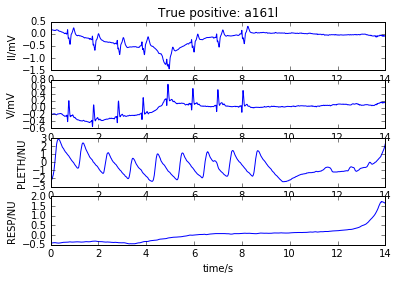

In [31]:
title = "True positive: a161l"
plot_signal(data_path, "a161l", title)

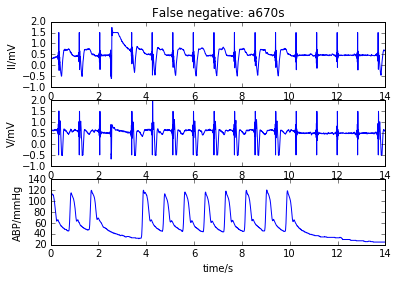

In [32]:
title = "False negative: a670s"
plot_signal(data_path, "a670s", title)